C:\Users\oztar\AppData\Local\Temp\ipykernel_17376\1150278982.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 5600000, number of used features: 108
[LightGBM] [Info] Start training from score -4.643521
[LightGBM] [Info] Start training from score -0.250531
[LightGBM] [Info] Start training from score -1.684056
[LightGBM] [Info] Start training from score -3.635549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

c:\Users\oztar\miniconda3\envs\pycaret-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\oztar\miniconda3\envs\pycaret-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\oztar\miniconda3\envs\pycaret-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     13473
           2       0.78      1.00      0.88   1089742
           3       0.48      0.01      0.02    259867
           4       0.25      0.00      0.00     36918

    accuracy                           0.78   1400000
   macro avg       0.38      0.25      0.22   1400000
weighted avg       0.70      0.78      0.69   1400000

Confusion Matrix:
[[      0   13471       2       0]
 [      0 1087527    2212       3]
 [      0  257256    2611       0]
 [      0   36288     629       1]]


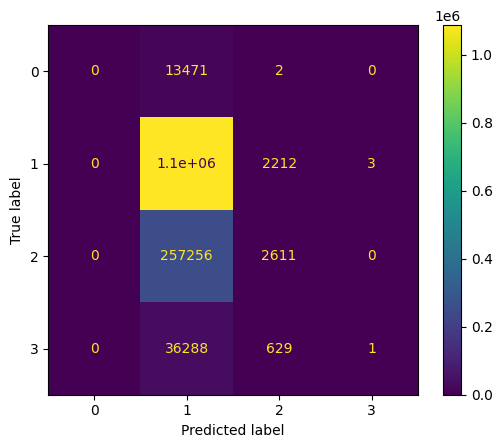

In [3]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier  # Use LightGBM for faster training
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import joblib
import matplotlib.pyplot as plt

# Database connection parameters
db_name = 'TrafficData'
db_user = 'postgres'
db_password = 'pavlov3'
db_host = 'localhost'
db_port = '5432'

# Create a connection string
connection_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Create a database engine
engine = create_engine(connection_string)

# Query to load data
query = "SELECT * FROM accidents2 LIMIT 7000000"

# Load data into a Pandas DataFrame
data = pd.read_sql(query, engine)

# Ensure all categorical columns are converted to strings
categorical_features = [
    'weather_condition', 'junction', 'traffic_signal', 
    'roundabout', 'traffic_calming', 'stop', 'railway', 'no_exit', 'bump'
]

for col in categorical_features:
    if col in data.columns:
        data[col] = data[col].astype('category')  # Use category dtype for efficiency

# Feature Engineering
data['start_hour'] = pd.to_datetime(data['start_time']).dt.hour

# Drop irrelevant columns
columns_to_keep = [
    'start_hour', 'weather_condition', 'junction', 'traffic_signal', 
    'roundabout', 'traffic_calming', 'stop', 'railway', 'no_exit', 'bump', 'severity'
]

data = data[columns_to_keep]

# Handle remaining missing values
data = data.fillna(method='ffill').fillna(method='bfill')

# Split the data into training and holdout test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=123, stratify=data['severity'])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['start_hour']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define a classifier
classifier = LGBMClassifier(random_state=123)

# Build a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Define hyperparameters for tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the pipeline
grid_search.fit(train_data.drop(columns=['severity']), train_data['severity'])

# Save the best model
joblib.dump(grid_search.best_estimator_, 'best_tuned_model.pkl')

# Load the model (for testing purposes)
model = joblib.load('best_tuned_model.pkl')

# Make predictions on the test set
predictions = model.predict(test_data.drop(columns=['severity']))

# Evaluate the model
accuracy = accuracy_score(test_data['severity'], predictions)
print(f"Accuracy: {accuracy}")

# Detailed classification report
report = classification_report(test_data['severity'], predictions)
print("Classification Report:")
print(report)

# Display the confusion matrix
conf_matrix = confusion_matrix(test_data['severity'], predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()
